In [57]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Asus\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [58]:
data = pd.read_csv("./data/RegularSeasonCompactResults.csv")

In [59]:
data.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [60]:
teams = list(data.Wteam.unique())

In [61]:
start_year = 2000
stop_year = 2015


In [62]:
sm = np.zeros((len(data.Wteam.value_counts()), len(data.Wteam.value_counts())))
ngames = np.zeros((len(data.Wteam.value_counts()), len(data.Wteam.value_counts())))

In [63]:
for wteam, lteam, wscore, lscore in zip(data.Wteam[(data.Season <= stop_year) * (data.Season > start_year)], 
                                        data.Lteam[(data.Season <= stop_year) * (data.Season > start_year)], 
                                        data.Wscore[(data.Season <= stop_year) * (data.Season > start_year)], 
                                        data.Lscore[(data.Season <= stop_year) * (data.Season > start_year)]):
    sm[teams.index(wteam), teams.index(lteam)] += 1
    sm[teams.index(lteam), teams.index(wteam)] -= 1
    ngames[teams.index(wteam), teams.index(lteam)] += 1
    ngames[teams.index(lteam), teams.index(wteam)] += 1

C:\Users\Asus\Anaconda3\lib\site-packages\pandas\computation\expressions.py:182: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


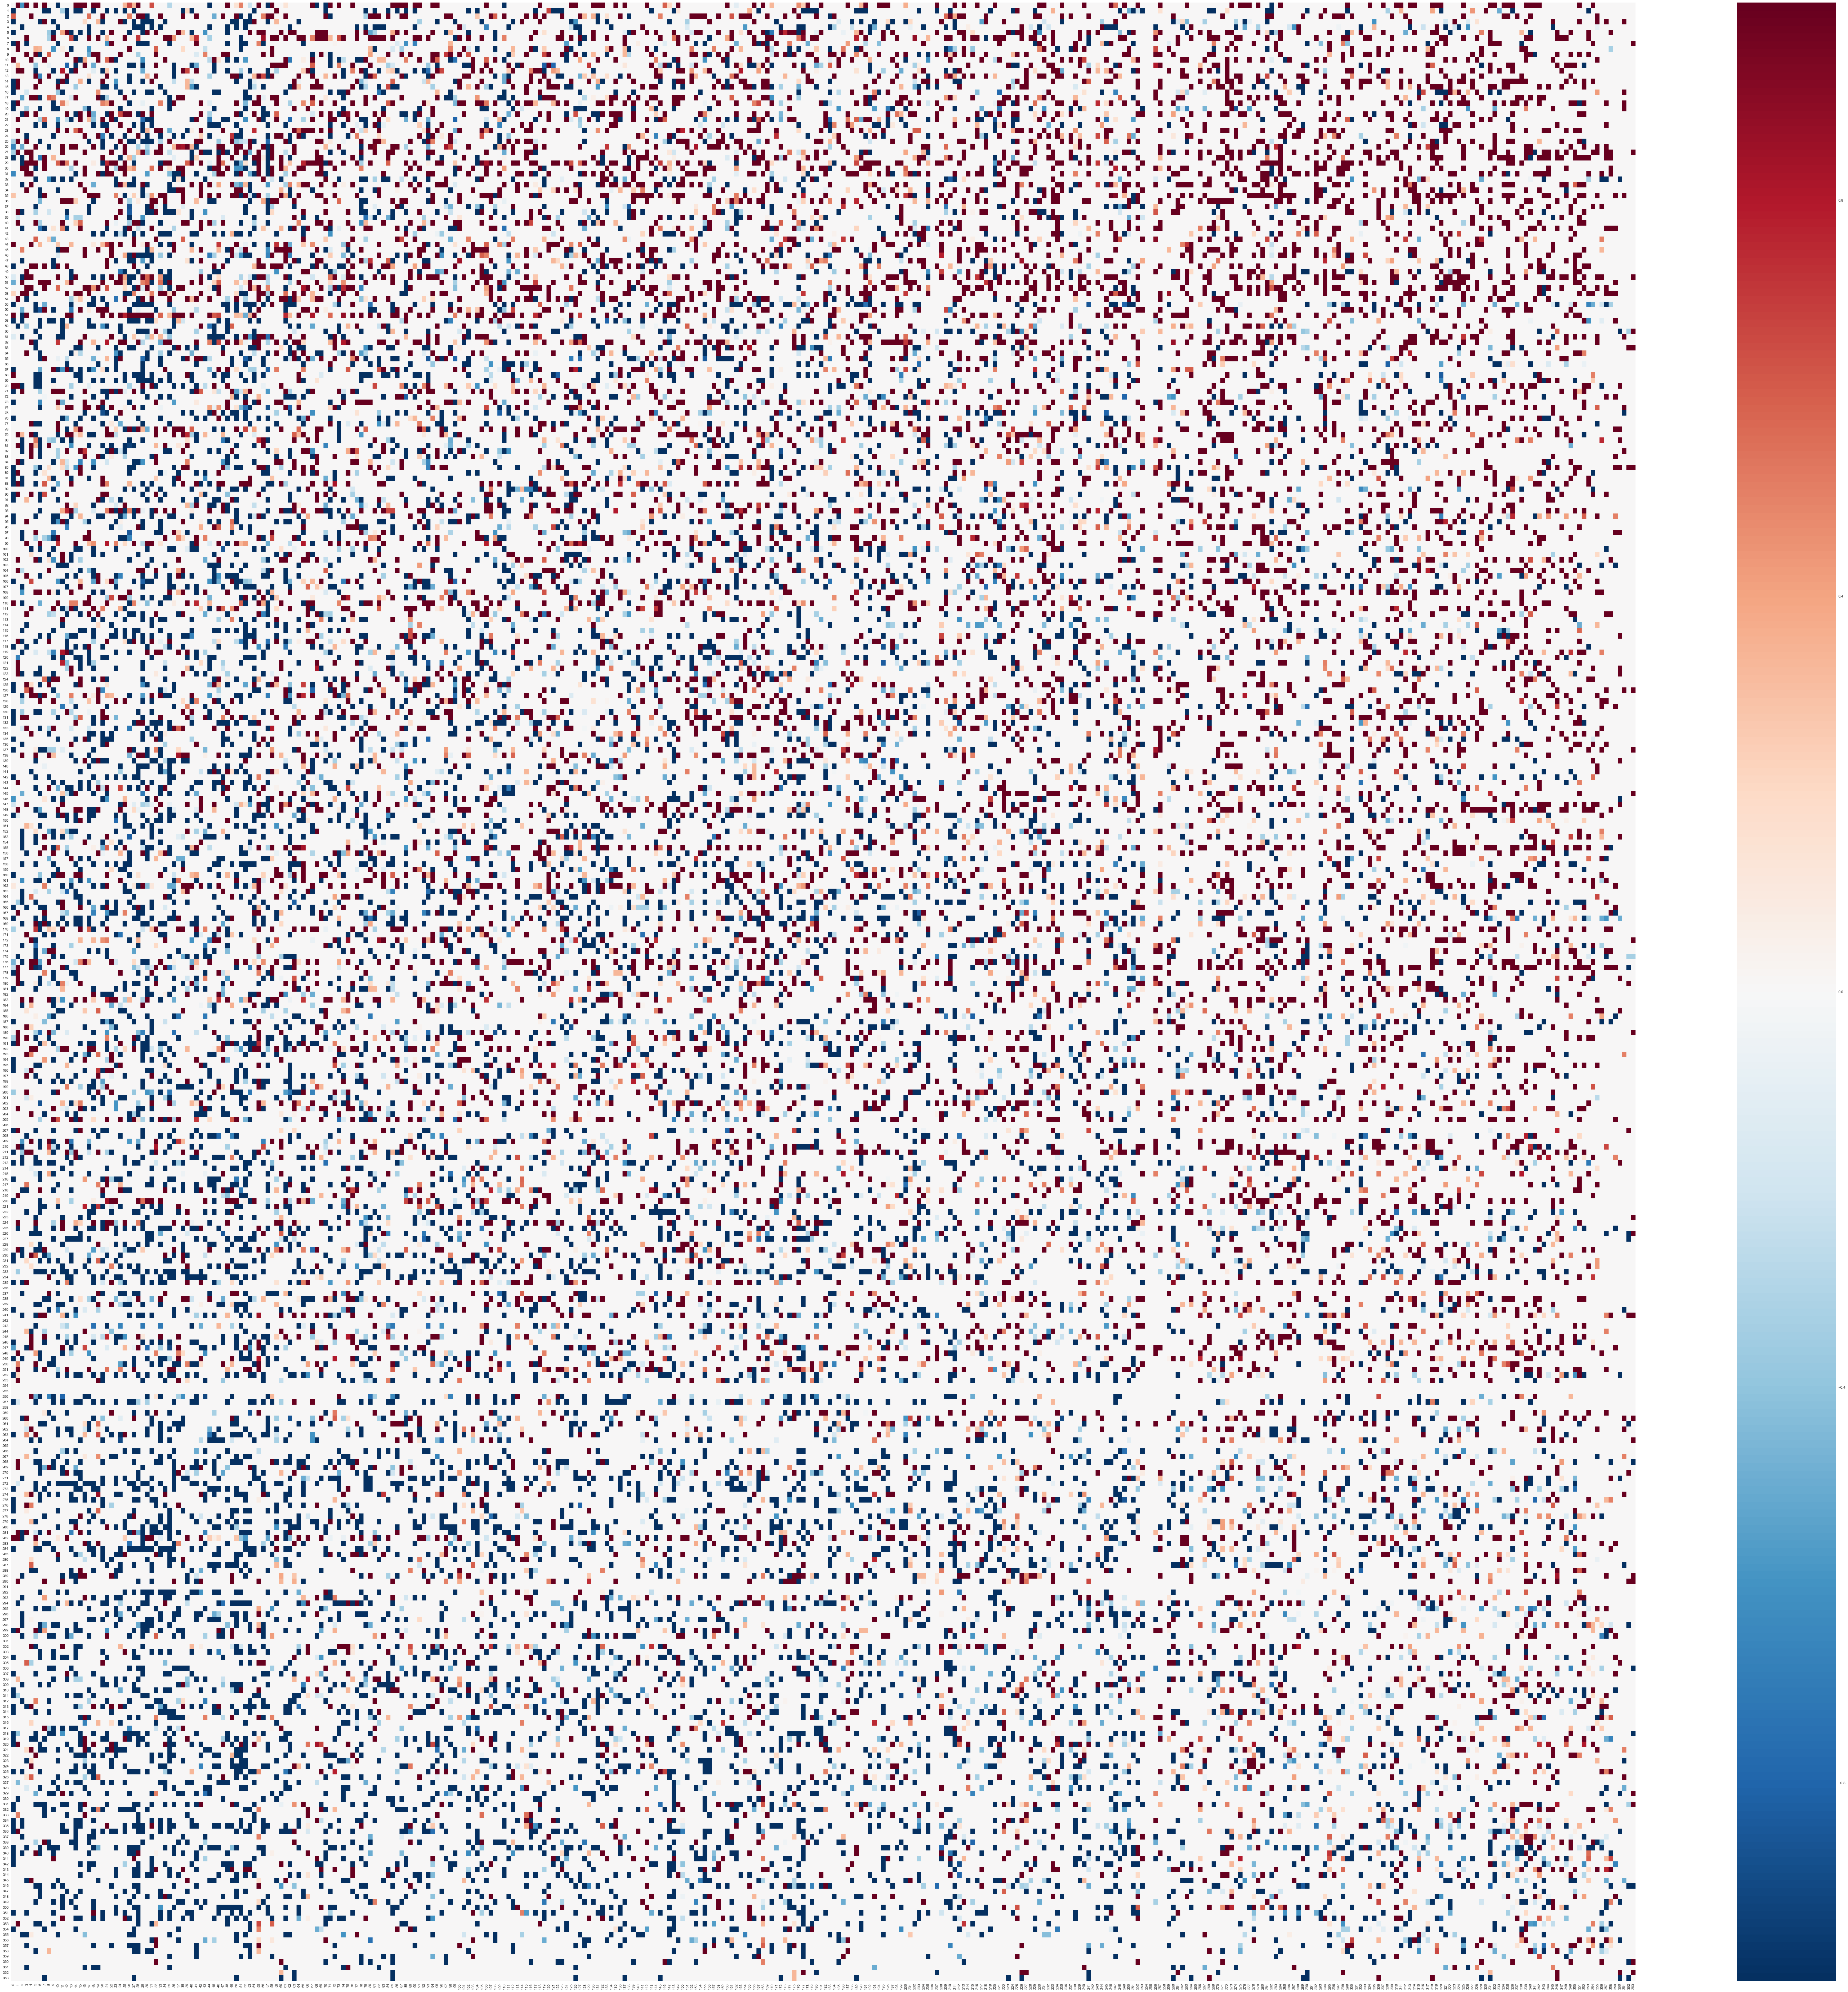

In [64]:
dense_sm = sm/ngames
dense_sm[np.isnan(dense_sm)] = 0
pylab.figure(figsize=(100,100))
sns.heatmap(dense_sm)

In [65]:
team_df = pd.DataFrame(dense_sm, teams, teams)

In [253]:
train = np.vstack([data[["Wteam", "Lteam"]][(data.Season <= stop_year) * (data.Season > start_year)].as_matrix(), 
                   data[["Lteam", "Wteam"]][(data.Season <= stop_year) * (data.Season > start_year)].as_matrix()])
y = np.hstack([np.ones(sum((data.Season <= stop_year) * (data.Season > start_year))), 
               np.zeros(sum((data.Season <= stop_year) * (data.Season > start_year)))])

C:\Users\Asus\Anaconda3\lib\site-packages\pandas\computation\expressions.py:182: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


In [254]:
test = np.vstack([data[["Wteam", "Lteam"]][data.Season > stop_year].as_matrix(), 
                   data[["Lteam", "Wteam"]][data.Season > stop_year].as_matrix()])
y_test = np.hstack([np.ones(sum((data.Season > stop_year))), np.zeros(sum((data.Season > stop_year)))])

In [255]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [256]:
idx = np.vectorize(lambda x: teams.index(x))
dense_sm[[idx(train[:,0])]].shape

(149788, 364)

In [257]:
train_dataset = np.hstack([dense_sm[[idx(train[:,0])]], dense_sm[[idx(train[:,1])]]])
test_dataset = np.hstack([dense_sm[[idx(test[:,0])]], dense_sm[[idx(test[:,1])]]])

In [262]:
lr = LogisticRegression(C = 10)

In [263]:
%%time
lr.fit(train_dataset, y)

Wall time: 2min 31s


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [264]:
log_loss(y_test, lr.predict_proba(test_dataset))

0.6120607924003173

In [192]:
log_loss(y_test, lr.predict_proba(test_dataset))

0.61237268010942592

In [148]:
log_loss(y_test, lr.predict_proba(test_dataset))

0.61277573504713068

In [116]:
sum((data.Season <= 2010) * (data.Season > 2000))

C:\Users\Asus\Anaconda3\lib\site-packages\pandas\computation\expressions.py:182: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


48359

# Additional Features

In [80]:
team_df = team_df.reset_index()

In [135]:
mean_param = pd.read_csv("./data/Mean_team_param.csv")

In [136]:
tdf_new = team_df.merge(mean_param, left_on="index", right_on="Wteam").drop("Wteam", 1)

In [137]:
td = pd.read_csv("./data/TourneyDetailedResults.csv")

In [138]:
td_num_games = td.groupby(["Season", "Wteam"]).count()
seasons = [2011, 2012, 2013, 2014, 2015, 2016]
wins = np.zeros((len(teams), 6))
for i, season in enumerate(seasons):
    for j in td_num_games.loc[season-1].index:
        wins[teams.index(j), i] = td_num_games.loc[season-1, j][0]

In [139]:
wins = pd.DataFrame(wins, index = teams).reset_index()

In [140]:
tdf_new = tdf_new.merge(wins, on="index", how = "outer").fillna(0)

In [141]:
cr = pd.read_csv("eloSeasonMelted.csv")
cr.head()

,Team_Name,Season,Rating,Team,TeamId
0,Abilene Chr,1985,1500.000000,1101,1985_1101
1,Air Force,1985,1403.823440,1102,1985_1102
2,Akron,1985,1459.058103,1103,1985_1103
3,Alabama,1985,1590.615989,1104,1985_1104
4,Alabama A&M,1985,1500.000000,1105,1985_1105


In [142]:
elo = np.zeros((len(teams), 6))
for i, season in enumerate(seasons):
    for j in cr.Team.unique():
        elo[teams.index(j), i] = cr.Rating[(cr.Season == season-1) * (cr.Team == j)]

C:\Users\Asus\Anaconda3\lib\site-packages\pandas\computation\expressions.py:182: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


In [143]:
elo = pd.DataFrame(elo, index = teams).reset_index()
tdf_new = tdf_new.merge(elo, on="index", how = "outer").fillna(0)

In [144]:
cr = pd.read_csv("PomeryRatings.csv")
cr.columns

Index(['Season', 'Rank', 'Team', 'Conf', 'W-L', 'AdjEM', 'AdjO', 'AdjD',
       'AdjT', 'Luck', 'schedule_AdjEM', 'schedule_OppO', 'schedule_OppD',
       'conf_AdjEM', 'team_id', 'alternative_spelling', 'match_rating'],
      dtype='object')

In [145]:
cr.head()

,Season,Rank,Team,Conf,W-L,AdjEM,AdjO,AdjD,AdjT,Luck,schedule_AdjEM,schedule_OppO,schedule_OppD,conf_AdjEM,team_id,alternative_spelling,match_rating
0,2002,1,duke,ACC,31-4,275,110,96,117,24,195,72,95,291,1181,duke,1.0
1,2002,2,cincinnati,CUSA,31-4,274,106,97,52,81,275,50,96,267,1153,cincinnati,1.0
2,2002,3,maryland,ACC,32-4,259,109,101,109,102,197,73,94,265,1268,maryland,1.0
3,2002,4,kansas,B12,31-4,258,108,100,123,100,201,76,99,300,1242,kansas,1.0
4,2002,5,oklahoma,B12,31-5,257,97,98,48,119,299,72,102,224,1328,oklahoma,1.0


In [146]:
cr.Season.unique()

array([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017], dtype=int64)

In [147]:
pr16 = cr[['AdjEM', 'AdjO', 'AdjD',
       'AdjT', 'Luck', 'schedule_AdjEM', 'schedule_OppO', 'schedule_OppD',
       'conf_AdjEM', 'team_id']][cr.Season == 2016]
pr17 = cr[['AdjEM', 'AdjO', 'AdjD',
       'AdjT', 'Luck', 'schedule_AdjEM', 'schedule_OppO', 'schedule_OppD',
       'conf_AdjEM', 'team_id']][cr.Season == 2017]

In [148]:
tdf_new = tdf_new.merge(pr16, left_on="index", right_on="team_id", how = "outer").drop("team_id", 1).fillna(0)

In [149]:
tdf_new.to_csv("tdf_new16.csv", index = None)

# NN

In [1]:
import keras
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import Adam

import pandas as pd
import numpy as np
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


C:\Users\Asus\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['multiply', 'maximum', 'add', 'concatenate', 'average', 'copy', 'dot']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [151]:
data = pd.read_csv("./data/RegularSeasonCompactResults.csv")

In [152]:
teams_data = pd.read_csv("tdf_new16.csv")

In [153]:
start_year = 2000
stop_year = 2015

In [154]:
idx = np.vectorize(lambda x: teams.index(x))
teams = list(teams_data["index"])
teams_data = teams_data.drop(["index"], 1)

In [155]:
train = np.vstack([data[["Wteam", "Lteam"]][(data.Season <= stop_year) * (data.Season > start_year)].as_matrix(), 
                   data[["Lteam", "Wteam"]][(data.Season <= stop_year) * (data.Season > start_year)].as_matrix()])
y = np.hstack([np.ones(sum((data.Season <= stop_year) * (data.Season > start_year))), 
               np.zeros(sum((data.Season <= stop_year) * (data.Season > start_year)))])
train_dataset = np.hstack([teams_data.as_matrix()[[idx(train[:,0])]], 
                           teams_data.as_matrix()[[idx(train[:,1])]]])

C:\Users\Asus\Anaconda3\lib\site-packages\pandas\computation\expressions.py:182: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


In [156]:
test = np.vstack([data[["Wteam", "Lteam"]][data.Season > stop_year].as_matrix(), 
                   data[["Lteam", "Wteam"]][data.Season > stop_year].as_matrix()])
y_test = np.hstack([np.ones(sum((data.Season > stop_year))), np.zeros(sum((data.Season > stop_year)))])
test_dataset = np.hstack([teams_data.as_matrix()[[idx(test[:,0])]],
                          teams_data.as_matrix()[[idx(test[:,1])]]])

In [164]:
model = Sequential()
model.add(Dense(512, input_dim=798, init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(512,  init='uniform', activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(256,  init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, init='uniform', activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(128, init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, init='uniform', activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(32, init='uniform', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, init='uniform', activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(1, init='uniform', activation='sigmoid'))
model.summary()

C:\Users\Asus\Anaconda3\lib\site-packages\keras\legacy\interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, input_dim=798, activation="relu", kernel_initializer="uniform")`
  '` call to the Keras 2 API: ' + signature)
C:\Users\Asus\Anaconda3\lib\site-packages\keras\legacy\interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="sigmoid", kernel_initializer="uniform")`
  '` call to the Keras 2 API: ' + signature)
C:\Users\Asus\Anaconda3\lib\site-packages\keras\legacy\interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="uniform")`
  '` call to the Keras 2 API: ' + signature)
C:\Users\Asus\Anaconda3\lib\site-packages\keras\legacy\interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="sigmoid", kernel_initializer="uniform")`
  '` call to the Keras 2 API: ' + signature)
C:\Users\Asus\Anaconda3\lib

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 512)               409088    
_________________________________________________________________
dropout_57 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_58 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_59 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 256)               65792     
__________

C:\Users\Asus\Anaconda3\lib\site-packages\keras\legacy\interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  '` call to the Keras 2 API: ' + signature)
C:\Users\Asus\Anaconda3\lib\site-packages\keras\legacy\interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="sigmoid", kernel_initializer="uniform")`
  '` call to the Keras 2 API: ' + signature)
C:\Users\Asus\Anaconda3\lib\site-packages\keras\legacy\interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  '` call to the Keras 2 API: ' + signature)


In [165]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=["accuracy","binary_crossentropy"])

In [166]:
history = model.fit(train_dataset, y,
                    batch_size=256, epochs=50,
                    verbose=1, validation_data=(test_dataset, y_test))

Train on 149788 samples, validate on 10738 samples
Epoch 1/50
149788/149788 [==============================] - 12s - loss: 0.6767 - acc: 0.5696 - binary_crossentropy: 0.6767 - val_loss: 0.6443 - val_acc: 0.6414 - val_binary_crossentropy: 0.6443

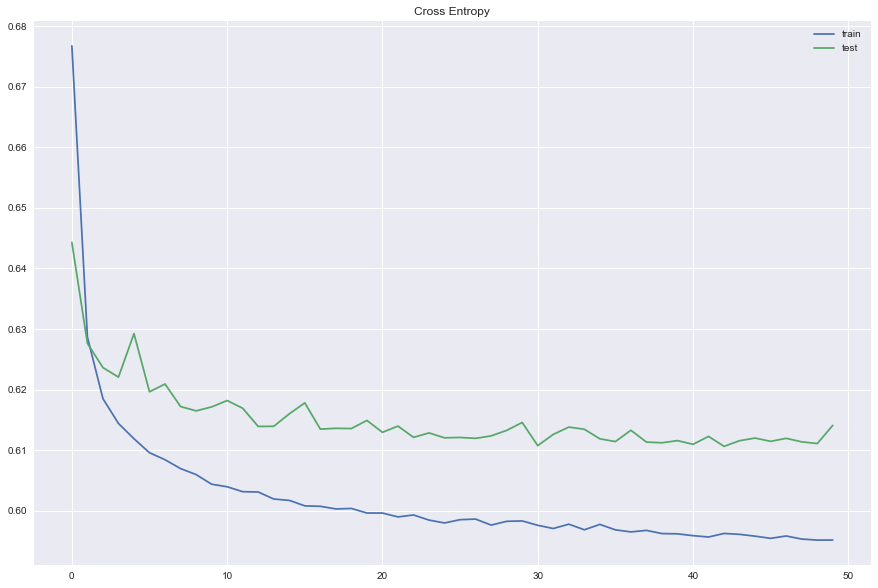

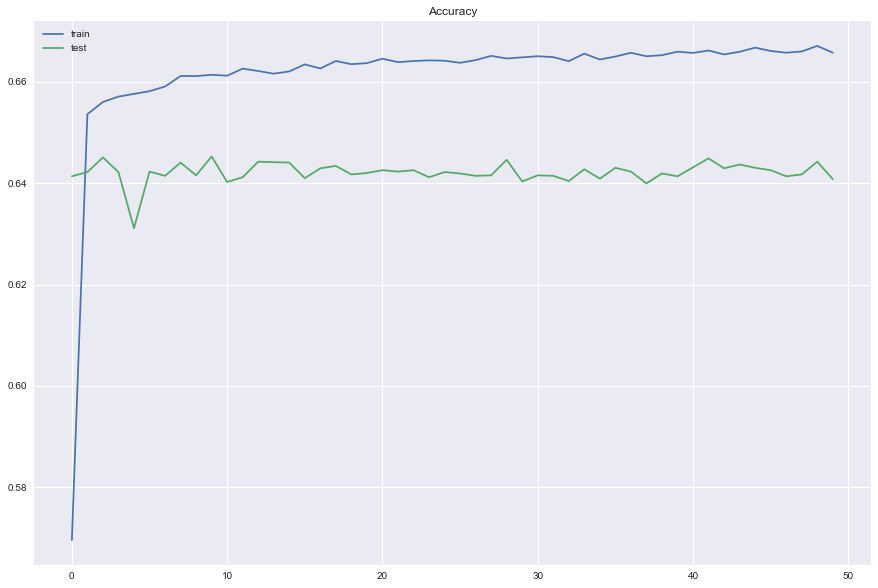

In [167]:
pylab.figure(figsize=(15,10))
pylab.plot(history.history['binary_crossentropy'], label = "train")
pylab.plot(history.history['val_binary_crossentropy'], label = "test")
pylab.title("Cross Entropy")
pylab.legend()
pylab.figure(figsize=(15,10))
pylab.title("Accuracy")
pylab.plot(history.history['acc'], label = "train")
pylab.plot(history.history['val_acc'], label = "test")
pylab.legend()

In [215]:
teams_data = pd.read_csv("tdf_new17.csv")

In [220]:
teams_data = teams_data.drop("index", 1)

In [221]:
cr =pd.read_csv("SampleSubmission.csv")
cr.head()

,Id,Pred
0,2017_1112_1116,0.5
1,2017_1112_1124,0.5
2,2017_1112_1137,0.5
3,2017_1112_1139,0.5
4,2017_1112_1153,0.5


In [222]:
test = []
for i in cr.Id:
    s = i.split("_")
    test.append([int(s[1]), int(s[2])])
test = np.array(test)
test_dataset = np.hstack([teams_data.as_matrix()[[idx(test[:,0])]],
                          teams_data.as_matrix()[[idx(test[:,1])]]])

In [223]:
ans = model.predict(test_dataset)

In [224]:
ans

array([[ 0.69995534],
       [ 0.60552585],
       [ 0.95228404],
       ..., 
       [ 0.04854743],
       [ 0.05155062],
       [ 0.61321247]], dtype=float32)

In [225]:
cr.Pred = ans.reshape(-1)

In [226]:
cr.to_csv("sub2.csv", index = None)

In [227]:
cr

,Id,Pred
0,2017_1112_1116,0.699955
1,2017_1112_1124,0.605526
2,2017_1112_1137,0.952284
3,2017_1112_1139,0.573942
4,2017_1112_1153,0.594834
5,2017_1112_1166,0.634276
6,2017_1112_1173,0.701858
7,2017_1112_1181,0.335973
8,2017_1112_1190,0.955417
9,2017_1112_1195,0.955724


In [71]:
sub = pd.read_csv("sub2.csv")

In [72]:
sub.head()

,Id,Pred
0,2017_1112_1116,0.699955
1,2017_1112_1124,0.605526
2,2017_1112_1137,0.952284
3,2017_1112_1139,0.573942
4,2017_1112_1153,0.594834


In [73]:
sub3, sub4 = sub,sub

In [74]:
sub4.Pred = (2*sub.Pred-1)*(2*sub.Pred-1)*(2*sub.Pred-1)/2+0.5

In [75]:
sub3.to_csv("sub5.csv", index = None)
#sub4.to_csv("sub4.csv", index = None)

(array([ 222.,   31.,   43.,  121.,  877.,  496.,  167.,   38.,   27.,  256.]),
 array([ 0.13136596,  0.20608932,  0.28081269,  0.35553606,  0.43025942,
         0.50498279,  0.57970616,  0.65442952,  0.72915289,  0.80387626,
         0.87859963]),
 <a list of 10 Patch objects>)

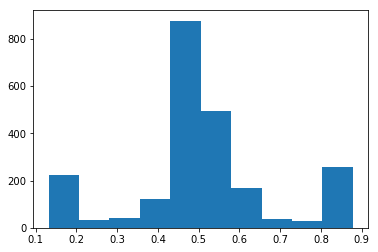

In [77]:
pylab.hist(sub3.Pred)

In [25]:
sub3

,Id,Pred
0,2017_1112_1116,0.639964
1,2017_1112_1124,0.564421
2,2017_1112_1137,0.841827
3,2017_1112_1139,0.539153
4,2017_1112_1153,0.555867
5,2017_1112_1166,0.587421
6,2017_1112_1173,0.641487
7,2017_1112_1181,0.348778
8,2017_1112_1190,0.844334
9,2017_1112_1195,0.844579
